利用朴素贝叶斯方法进行新闻文本的分类, 其中测试频率停用的敏感性

#### 加载停用词

In [3]:
def create_stop_words(stopword_file):
    stopwords = set()
    [stopwords.add(line.strip()) for line in open(stopword_file).readlines() if line and line.strip() not in stopwords]
    return stopwords

stopwords = create_stop_words('./data/News/stopwords_cn.txt')
stopwords

{'一',
 '一些',
 '一切',
 '一旦',
 '一来',
 '万一',
 '上',
 '下',
 '不',
 '不仅',
 '不仅仅',
 '不但',
 '不光',
 '不单',
 '不只',
 '不外乎',
 '不如',
 '不尽',
 '不尽然',
 '不料',
 '不是',
 '不然',
 '不管',
 '不至于',
 '不论',
 '不过',
 '与',
 '与其',
 '与否',
 '且',
 '两者',
 '个',
 '个人',
 '个别',
 '为',
 '为了',
 '为什么',
 '为何',
 '为止',
 '为此',
 '为着',
 '乃',
 '乃至',
 '么',
 '之',
 '之所以',
 '也',
 '了',
 '于',
 '于是',
 '些',
 '亦',
 '人',
 '人们',
 '什么',
 '什么样',
 '什么的',
 '今',
 '介于',
 '仍',
 '仍旧',
 '从',
 '从此',
 '从而',
 '他',
 '他人',
 '他们',
 '以',
 '以上',
 '以为',
 '以便',
 '以免',
 '以及',
 '以来',
 '以至',
 '以致',
 '们',
 '任何',
 '似的',
 '但',
 '但是',
 '何',
 '何以',
 '何况',
 '何处',
 '何时',
 '作为',
 '你',
 '你们',
 '使',
 '例如',
 '依据',
 '依照',
 '便于',
 '倘若',
 '值此',
 '假如',
 '儿',
 '光是',
 '全体',
 '全部',
 '关于',
 '其',
 '其中',
 '其他',
 '其余',
 '其它',
 '其次',
 '再',
 '再则',
 '再有',
 '况且',
 '几',
 '凡',
 '凡是',
 '凭',
 '凭借',
 '出于',
 '出来',
 '分别',
 '则',
 '别',
 '别人',
 '别处',
 '别的',
 '别说',
 '到',
 '前者',
 '加之',
 '加以',
 '即',
 '即使',
 '即便',
 '却',
 '去',
 '又',
 '又及',
 '及',
 '及至',
 '反之',
 '反而',
 '受到',
 '另',
 '另一方面',
 '另外',
 '只',
 '只因',
 '只怕

#### 读入文本数据，进行数据集划分和词库生成

In [25]:
import os
from sklearn.model_selection import train_test_split
import jieba
from multiprocessing import cpu_count
from collections import defaultdict

def text_processing(document_path, test_size=0.2):
    folder_list = os.listdir(document_path)   # 子文件夹名称
    data_list = []   # 存储文档
    class_list = []    #  存储label
    
    for folder in folder_list:
        if folder.startswith('.'):
            continue
        new_folder_path = os.path.join(document_path, folder)
        files = os.listdir(new_folder_path)
        j = 1  
        for file in files:
            if file.startswith('.'):
                continue
            if j > 100:   # 防止子文件下文件太多，内存爆掉
                break
            with open(os.path.join(new_folder_path, file), 'r', encoding='utf-8') as fp:
                raw = fp.read()
            
            # 分词
            jieba.enable_parallel(cpu_count())
            word_list = jieba.lcut(raw, cut_all=True)
            jieba.disable_parallel()
            
            data_list.append(word_list)
            class_list.append(folder)
            j += 1
            
    train_data, test_data, train_class, test_class = train_test_split(data_list, class_list, test_size=test_size)
    
    # 统计所有出现的词及词频
    all_words_dict = defaultdict(int)
    for word_list in train_data:
        for word in word_list:
            all_words_dict[word] += 1
    
    all_words_dict_sorted = sorted(all_words_dict.items(), key=lambda x:x[1], reverse=True)
    all_words_list = list(list(zip(*all_words_dict_sorted))[0])
    
    return all_words_list, train_data, test_data, train_class, test_class

#### 选取特征词

In [15]:
def generate_feature_words(all_words_list, deleteN=0, stopwords=set(), max_features=1000):
    # deleteN删除过频繁词，默认不删除; max_features为特征维度上限
    feature_words = []
    n = 1
    for i in range(deleteN, len(all_words_list)):
        if i > max_features:
            break
        
        word = all_words_list[i]
        if not word.isdigit() and word not in stopwords and 1<len(word)<5:
            feature_words.append(word)
            n+=1
    return feature_words

#### 生成文本特征

In [17]:
def data_features(train_data, test_data, feature_words, flag='nltk'):
    def extract_text_features(text, feature_words):
        text_words = set(text)
        
        # 根据所选的NLP库进行特征的生成
        if flag == 'nltk':
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == 'sklearn':
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []
        return features
    
    train_features = [extract_text_features(data, feature_words) for data in train_data]
    test_features = [extract_text_features(data, feature_words) for data in test_data]
    return train_features, test_features

#### NB模型训练和结果输出

In [23]:
from nltk.classify import NaiveBayesClassifier
from nltk.classify import accuracy
from sklearn.naive_bayes import MultinomialNB
def text_classifer(train_features, test_features, train_class, test_class, flag='nltk'):
    if flag == 'nltk':
        ## 使用nltk分类器
        train_flist = zip(train_features, train_class)
        test_flist = zip(test_features, test_class)
        classifier = NaiveBayesClassifier.train(train_flist)
        test_accuracy = accuracy(classifier, test_flist)
    elif flag == 'sklearn':
        ## sklearn分类器
        classifier = MultinomialNB().fit(train_features, train_class)
        test_accuracy = classifier.score(test_features, test_class)
    else:
        test_accuracy = []
    return test_accuracy

#### 6. 实例

In [27]:
# 1. 载入停用词
stopword_file = './data/News/stopwords_cn.txt'
stopwords = create_stop_words(stopword_file)

# 2. 载入文本
document_path = './data/News/Sample'
all_words_list, train_data, test_data, train_class, test_class = text_processing(document_path)

# 3. 生成文本特征
flag = 'sklearn'
deleteNs = range(0, 1000, 20) 
test_accuracy_list = []    # 记录结果

for deleteN in deleteNs:
    feature_words = generate_feature_words(all_words_list, deleteN=deleteN, stopwords=stopwords)
    train_features, test_features = data_features(train_data, test_data, feature_words, flag=flag)
    test_accuracy = text_classifer(train_features, test_features, train_class, test_class, flag=flag)
    test_accuracy_list.append(test_accuracy)
    print("The accuracy of {} deletes is {}".format(deleteN, test_accuracy))

The accuracy of 0 deletes is 0.6111111111111112
The accuracy of 20 deletes is 0.6111111111111112
The accuracy of 40 deletes is 0.6111111111111112
The accuracy of 60 deletes is 0.5555555555555556
The accuracy of 80 deletes is 0.5555555555555556
The accuracy of 100 deletes is 0.5555555555555556
The accuracy of 120 deletes is 0.6111111111111112
The accuracy of 140 deletes is 0.5555555555555556
The accuracy of 160 deletes is 0.5555555555555556
The accuracy of 180 deletes is 0.5555555555555556
The accuracy of 200 deletes is 0.5
The accuracy of 220 deletes is 0.5
The accuracy of 240 deletes is 0.5555555555555556
The accuracy of 260 deletes is 0.5555555555555556
The accuracy of 280 deletes is 0.5555555555555556
The accuracy of 300 deletes is 0.5555555555555556
The accuracy of 320 deletes is 0.5555555555555556
The accuracy of 340 deletes is 0.5555555555555556
The accuracy of 360 deletes is 0.5555555555555556
The accuracy of 380 deletes is 0.5555555555555556
The accuracy of 400 deletes is 0.555

Text(0, 0.5, 'test_accuracy')

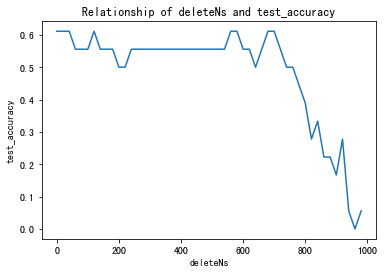

In [29]:
import matplotlib.pyplot as plt
plt.plot(deleteNs, test_accuracy_list)
plt.title('Relationship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')